<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/modern_approach/video_interpolation/film_for_vdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FILM for video diffusion models

In [ ]:
%pip install -q mediapy
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
from typing import Generator, Iterable, List, Optional
from PIL import Image
import mediapy as media

In [2]:
model = hub.load('https://tfhub.dev/google/film/1')

In [98]:
video_file = 'a_teddy_bear_dancing.mp4'
cap = cv2.VideoCapture(video_file)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frames = []

for _ in range(n_frames):
  _, frame = cap.read()
  frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

cap.release()
frames = np.array(frames)
frames.shape

(16, 256, 256, 3)

In [92]:
def load_image(img):
  UINT8_MAX_F = float(np.iinfo(np.uint8).max)
  img_numpy = tf.cast(img, dtype=tf.float32).numpy()
  return img_numpy / UINT8_MAX_F

def film(img1, img2):
  time = np.array([0.5], dtype=np.float32)
  input = {
      'time': np.expand_dims(time, axis=0),
      'x0': np.expand_dims(img1, axis=0),
      'x1': np.expand_dims(img2, axis=0)
  }
  mid_frame = model(input)
  return mid_frame['image'][0].numpy()

First input image,Generated image,Second input image

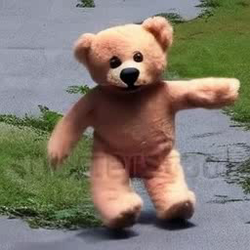
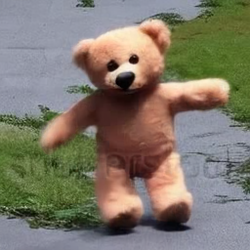
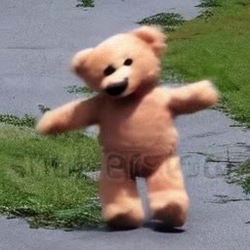

In [99]:
img1 = load_image(frames[0])
img2 = load_image(frames[5])

mid_frame = film(img1, img2)

output_frames = [img1, mid_frame, img2]
media.show_images(output_frames, titles=['First input image', 'Generated image', 'Second input image'], 
                  height=250)

In [100]:
output_frames = [img1]

for i in range(n_frames - 1):
  img1 = load_image(frames[i])
  img5 = load_image(frames[i + 1])

  img3 = film(img1, img5)
  img2 = film(img1, img3)
  img4 = film(img3, img5)

  output_frames.append(img2)
  output_frames.append(img3)
  output_frames.append(img4)
  output_frames.append(img5)

  print(f'{4 * (i+1)}/{4 * n_frames} frames processed.')

output_frames = np.array(output_frames)
output_frames.shape

4/64 frames processed.
8/64 frames processed.
12/64 frames processed.
16/64 frames processed.
20/64 frames processed.
24/64 frames processed.
28/64 frames processed.
32/64 frames processed.
36/64 frames processed.
40/64 frames processed.
44/64 frames processed.
48/64 frames processed.
52/64 frames processed.
56/64 frames processed.
60/64 frames processed.


(61, 256, 256, 3)

In [101]:
output_filename = 'result.mp4'
fps = 16
resolution = (256, 256)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(output_filename, fourcc, fps, resolution)

for frame in output_frames:
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
  frame = (frame * 255).astype(np.uint8)
  writer.write(frame)

writer.release()